### Description

This notebook implements a basic neuron using a modified signal. i.e. instead of calculating signal as:

`signal = 1/mean_squared_error(neuron_weights, input_pattern)`

The InvertedNeuron calculates it as 

`signal = mean_squared_error(neuron_weights, input_pattern)`

This only required a slight modification in the weight and threshold update logic. The most notable difference being the Neuron now activates when `signal <= threshold` instead of when `signal >= threshold` which makes threshold an upper bound rather than a lower bound.

The main motivation for the InvertedNeuron is efficiency. The original Neuron required a threshold which could approach infinity. This is very inefficient and does not scale well to large datasets since the threshold grows proportionally to the size of the dataset.

Additionally, the InvertedNeuron experiments with using smaller, more efficient datatypes such as `np.float16`.
Currently the improvements offered by the InvertedNeuron are backed only by intuition. More work needs to be done to compare the InvertedNeuron to the original Neuron.


### Update After Comparison to the original Neuron
The InvertedNeuron did not offer the expected space improvement. This is due to the original Neuron using floating point values to avoid storing large integers.
The InvertedNeuron is potentially still worth pursuing as it has arguably simpler activation logic.

In [1]:
import numpy as np
import math
from InvertedNeuron import InvertedNeuron, OriginalNeuron

In [2]:
from collections import deque
import matplotlib.pyplot as plt


np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# plot the 2D matrix heatmap
# supports a 2D array, or flattened (uses DIMS to restore 1D to 2D)
def plot_matrix(dims, *datas):
    PLOTS_PER_ROW = 20
    cols = min(len(datas), PLOTS_PER_ROW)
    rows = math.ceil(len(datas)/PLOTS_PER_ROW)
    fig = plt.figure(figsize=(cols,rows))
    for i, data in enumerate(datas):
        if data.shape != dims:
            data = np.reshape(data, dims)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        # plt.title(f"#{i}")
    plt.show()
    
    

In [3]:
# Define input patterns

DIMS = [7,7]

patterns = np.array([
    np.array([
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,0,1,0,0],
        [0,0,0,1,0,0,0],
        [0,0,1,0,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1]
    ]),
    np.array([
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [1,1,1,1,1,1,1],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0]
    ]),
    np.array([
        [0,0,1,1,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,1,1,0,0]
    ]),
    np.array([
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0]
    ]),
    np.array([
        [1,1,1,0,0,0,0],
        [1,1,1,0,0,0,0],
        [1,1,1,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0]
    ])
# np.array([
# [0,1,1,0],
# [1,0,0,1],
# [1,0,0,1],
# [0,1,1,0]
# ])
])

# Define probabilities

probs = np.full(len(patterns), 1) # np.array([0.43 0.43 0.13])
probs = probs / probs.sum()

def randomly_choose_input_idx(iteration):
    return np.random.choice(len(probs), p=probs)



### InvertedNeuron Example


----------------
Running frontprop on following patterns:


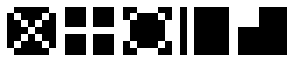

with probabilities:
[0.20 0.20 0.20 0.20 0.20]
 ... and noise prob 0



 --- Iter #0 --- 
Neurons' weights:


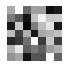

[0.67 1.00 0.43 0.63 0.62 0.08 0.13 0.49 0.36 0.10 0.77 0.94 0.78 0.80
 0.11 0.78 0.02 0.50 0.74 0.89 0.12 0.74 0.28 0.69 0.12 0.66 0.70 0.76
 0.17 0.24 0.44 0.99 0.25 0.79 0.25 0.71 0.90 0.38 0.48 0.39 0.61 0.70
 0.59 0.65 0.10 0.35 0.34 0.98 0.40] float16
Layer outputs:
12.49
Threshold:
1.005 float16

 --- Iter #500 --- 
Neurons' weights:


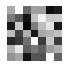

[0.67 1.00 0.43 0.63 0.62 0.08 0.13 0.49 0.36 0.10 0.77 0.94 0.78 0.80
 0.11 0.78 0.02 0.50 0.74 0.89 0.12 0.74 0.28 0.69 0.12 0.66 0.70 0.76
 0.17 0.24 0.44 0.99 0.25 0.79 0.25 0.71 0.90 0.38 0.48 0.39 0.61 0.70
 0.59 0.65 0.10 0.35 0.34 0.98 0.40] float16
Layer outputs:
12.49
Threshold:
11.36 float16

 --- Iter #1000 --- 
Neurons' weights:


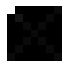

[24.23 0.01 0.00 0.01 0.00 0.00 0.98 0.00 1.95 0.00 0.01 0.01 0.98 0.01
 0.00 0.01 0.98 0.00 0.98 0.01 0.00 0.01 0.00 0.01 0.98 0.01 0.01 0.01
 0.00 0.00 0.98 0.01 0.98 0.01 0.00 0.01 0.98 0.00 0.00 0.00 0.98 0.01
 0.98 0.01 0.00 0.00 0.00 0.01 0.98] float16
Layer outputs:
0.01215
Threshold:
0.012215 float16

 --- Iter #1500 --- 
Neurons' weights:


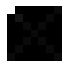

[24.23 0.00 0.00 0.00 0.00 0.00 0.98 0.00 1.95 0.00 0.00 0.00 0.98 0.00
 0.00 0.00 0.98 0.00 0.98 0.00 0.00 0.00 0.00 0.00 0.98 0.00 0.00 0.00
 0.00 0.00 0.98 0.00 0.98 0.00 0.00 0.00 0.98 0.00 0.00 0.00 0.98 0.00
 0.98 0.00 0.00 0.00 0.00 0.00 0.98] float16
Layer outputs:
0.01214
Threshold:
0.0122 float16


In [7]:
ITERS = 2000
VERBOSE = False
DRAW_INTERVAL = 500
# Throw in some noise inputs 
# (without noise at zero, it converges very quickly - noise rate increases slows down learning exponentially!)
NOISE_INPUTS_PROB = 0 # 0.02

neuron = InvertedNeuron(DIMS,  0.005,  0.01)

print("\n----------------\nRunning frontprop on following patterns:")
plot_matrix(DIMS, *patterns)
print(f"with probabilities:\n{probs}\n ... and noise prob {NOISE_INPUTS_PROB}\n\n")

for i in range(ITERS):
    
    if np.random.rand() < NOISE_INPUTS_PROB:
        input = np.random.rand(*DIMS).flatten()
    else:
        input_idx = randomly_choose_input_idx(i)
        input = patterns[input_idx].flatten()
    input = np.array([
        [25,0,0,0,0,0,1],
        [0,2,0,0,0,1,0],
        [0,0,1,0,1,0,0],
        [0,0,0,1,0,0,0],
        [0,0,1,0,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1]]).flatten()
    if VERBOSE:
        print(f"Iter #{i}: Feeding input pattern #{input_idx}")
        print(input)
        plot_matrix(input)
        
    out = neuron.forward(input)
    
    if i % DRAW_INTERVAL == 0:
        print(f"\n --- Iter #{i} --- ")
        print("Neurons' weights:")
        plot_matrix(neuron.dims, neuron.W)
        print(neuron.W, neuron.W.dtype)
        print("Layer outputs:")
        print(out)
        print("Threshold:")
        print(neuron.t, neuron.t.dtype)
    

### Comparison of InvertedNeuron to OriginalNeuron


----------------
Running frontprop on following pattern:


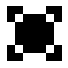

InvertedNeuron threshold: 			0.00018787384033203125
Size of InvertedNeuron threshold: 		26 bytes
Elapsed execution time of InvertedNeuron: 	13.354985237121582 seconds
OriginalNeuron threshold: 			9.888688802260371e+28
Size of OriginalNeuron threshold: 		32 bytes
Elapsed execution time of OriginalNeuron: 	11.46970009803772 seconds


In [6]:
from sys import getsizeof
import time

ITERS = 80000
DRAW_INTERVAL = ITERS-1
# Throw in some noise inputs 
# (without noise at zero, it converges very quickly - noise rate increases slows down learning exponentially!)
NOISE_INPUTS_PROB = 0 # 0.02

inverted_neuron = InvertedNeuron(DIMS,  0.005,  0.01)
original_neuron = OriginalNeuron(DIMS,  0.005,  0.01)

pattern = np.array([
        [0,0,1,1,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,1,1,0,0]]).flatten()

print("\n----------------\nRunning frontprop on following pattern:")
plot_matrix(DIMS, pattern)

original_neuron_start_time = time.time()

for _ in range(ITERS):
    original_out = original_neuron.forward(pattern)
    
original_neuron_end_time = time.time()

inverted_neuron_start_time = time.time()

for _ in range(ITERS):
    inverted_out = inverted_neuron.forward(pattern)
    
inverted_neuron_end_time = time.time()

inverted_neuron_elapsed_time = inverted_neuron_end_time - inverted_neuron_start_time
original_neuron_elapsed_time = original_neuron_end_time - original_neuron_start_time

# print("Inverted neurons' weights:")
# plot_matrix(inverted_neuron.dims, inverted_neuron.W)
print(f"InvertedNeuron threshold: \t\t\t{inverted_neuron.t}")
print(f"Size of InvertedNeuron threshold: \t\t{getsizeof(inverted_neuron.t)} bytes")
print(f"Elapsed execution time of InvertedNeuron: \t{inverted_neuron_elapsed_time} seconds")

# print("Original neurons' weights:")
# plot_matrix(original_neuron.dims, original_neuron.W)
print(f"OriginalNeuron threshold: \t\t\t{original_neuron.t}")
print(f"Size of OriginalNeuron threshold: \t\t{getsizeof(original_neuron.t)} bytes")
print(f"Elapsed execution time of OriginalNeuron: \t{original_neuron_elapsed_time} seconds")



### Random Notes 

Let N be the length of the input vector

if input/weight vector values are in [0,1] => mean_squared_error in [0, 1] => 1/mean_squared_error in [1, inf]

When W highly similar to data:
- mean_squared_error -> 0
- signal = 1/mean_squared_error -> inf

When W has zero similarity to data:
- mean_squared_error -> 1
- 1/mean_squared_error -> 1